In [1]:
# Import Packages
library(rpart)
library(ggplot2)

In [2]:
# creating data with weather data on Outlook, Temperature, Humidity and Wind as independent variable 
# and whether golfer will play golf or not as dependent variable ####
mydf <- data.frame(
  Outlook = c("Rainy", "Rainy", "Overcast", "Sunny", "Sunny", "Sunny", "Overcast", "Rainy", "Rainy", "Sunny", "Rainy", "Overcast", "Overcast", "Sunny"),
  Temp = c("Hot", "Hot", "Hot", "Mild", "Cool", "Cool", "Cool", "Mild", "Cool", "Mild", "Mild", "Mild", "Hot", "Mild"),
  Humidity = c("High", "High", "High", "High", "Normal", "Normal", "Normal", "High", "Normal", "Normal", "Normal", "High", "Normal", "High"),
  Windy = c("False", "True", "False", "False", "False", "True", "True", "False", "False", "False", "True", "True", "False", "True"),
  PlaysGolf = c("No", "No", "Yes", "Yes", "Yes", "No", "Yes", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "No")
)

In [6]:
head(mydf)

,Outlook,Temp,Humidity,Windy,PlaysGolf
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Rainy,Hot,High,False,No
2,Rainy,Hot,High,True,No
3,Overcast,Hot,High,False,Yes
4,Sunny,Mild,High,False,Yes
5,Sunny,Cool,Normal,False,Yes
6,Sunny,Cool,Normal,True,No


In [3]:
# What attribute should we use first to begin splitting our data? 
# We need to understand Entropy and Information Gain.

# Entropy tells us how pure of impure is a subset named S. This is the formula:
# E(S) = -p(+) log2 p(+) - p(-) log2 p(-)
# S = subset of training examples
# p(+) and p(-) = % of positve / negative examples in S
# It will be 0 for a pure set and 1 for a totally impure set (split 50/50)
  # totally impure set (3 yes / 3 no):
  -(3/6) * log(3/6, base = 2) - (3/6) * log(3/6, base = 2) # Entropy = 1
  # pure set (4 yes / 0 no):
  -(4/4) * log(4/4, base = 2) - (0/4) * log(0/4, base = 2) # Entropy = NaN = 0

[1] 1

[1] NaN

In [4]:
# We will write a function for entropy, so it's easier to calculate:
entropy <- function(p){
  ifelse(p==0|p==1, 0, -(p) * log(p, base = 2) - (1-p) * log(1-p, base = 2)) # we need to manually set values for p = 0 and p = 1, otherwise we'll get Nan
}
  #Checking our function:
  entropy(0) # pure set = 0
  entropy(0.5) # 50/50 split set = 1
  entropy(1) # pure set = 0

[1] 0

[1] 1

[1] 0

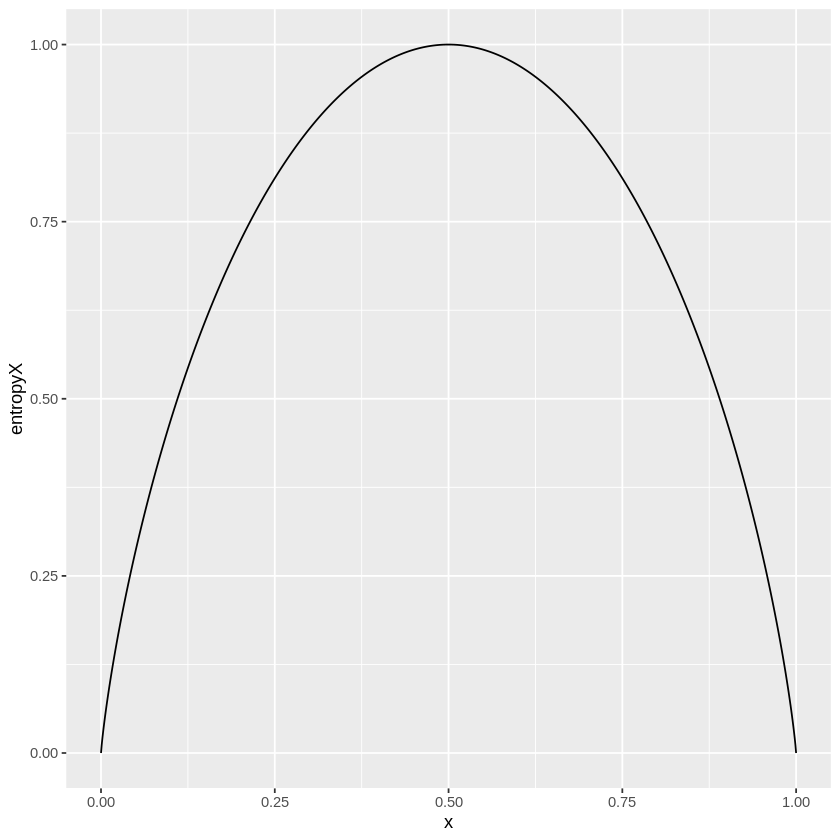

In [5]:
#Plotting our function:
  x <- seq(from = 0, to = 1, by = 0.001)
  entX <- data.frame(
    x = x,
    entropyX = entropy(x)
  )
  ggplot(data = entX, aes(x, entropyX)) +
    geom_line()


In [7]:
# The entropy for the initial node is:
table(mydf$PlaysGolf)
  #PNo Yes 
  # 5   9
    print(ePlaysGolf <- entropy(9/14)) # 0.940286


 No Yes 
  5   9 

[1] 0.940286


In [8]:
# Let's calculate entropy for two attributes
# We do it by taking the weighted average of the entropy for each branch. 
# The weight is the size of this subset divided by the overall number of examples
  
# PlaysGolf - Outlook
  table(mydf$PlaysGolf, mydf$Outlook)
  # PlaysGolf   Overcast Rainy Sunny
  # No          0        3     2
  # Yes         4        2     3
  eOvercast <- entropy(4/4) # 0
  eRainy <- entropy(2/5) # 0.971
  eSunny <- entropy(3/5) # 0.971
  
  ePlayOutlook <- 4/14 * eOvercast + 5/14 * eRainy + 5/14 * eSunny #0.6935361

     
      Overcast Rainy Sunny
  No         0     3     2
  Yes        4     2     3

In [9]:
# PlaysGolf - Wind
  table(mydf$PlaysGolf, mydf$Wind)
  # PlaysGolf   False True
  # No          2     3
  # Yes         6     3
  eWindF <- entropy(6/8) # 0.8112781
  eWindT <- entropy(3/6) # 1
  
    ePlayWind <- 8/14 * eWindF + 6/14 * eWindT #0.8921589

     
      False True
  No      2    3
  Yes     6    3

In [10]:
# PlaysGolf - Temp
  table(mydf$PlaysGolf, mydf$Temp)
  # PlaysGolf Cool Hot Mild
  # No        1   2    2
  # Yes       3   2    4
  
  eCool <- entropy(3/4) # 0.8112781
  eHot <- entropy(2/4) # 1
  eMild <- entropy(4/6) # 0.9182958
  
    ePlayTemp <- 4/14 * eCool + 4/14 * eHot + 6/14 * eMild #0.9110634

     
      Cool Hot Mild
  No     1   2    2
  Yes    3   2    4

In [11]:
# PlaysGolf - Humidity
  table(mydf$PlaysGolf, mydf$Humidity)
  # PlaysGolf High  Normal 
  # No        4     1  
  # Yes       3     6
    
    eHighHum <- entropy(3/7) # 0.9852281
    eNormalHum <- entropy(6/7) # 0.5916728

    ePlayHum <- 8/14 * eHighHum + 6/14 * eNormalHum #0.8165616

     
      High Normal
  No     4      1
  Yes    3      6

In [12]:
# Information Gain: is the decrease in entropy for a split.
    # Gain(T, X) = Entropy(T) - Entropy(T, X)
    ePlaysGolf - ePlayOutlook # 0.2467498
    ePlaysGolf - ePlayWind # 0.04812703
    ePlaysGolf - ePlayTemp # 0.02922257
    ePlaysGolf - ePlayHum # 0.1237244

[1] 0.2467498

[1] 0.04812703

[1] 0.02922257

[1] 0.1237244

In [13]:
# We now pick the attribute with the largest information gain: Outlook. 
# We make the split and we repeat the process for all the branches 
# (except for those ones that have entropy = 0, that become final nodes - also called leaves)

# We can now fit a decision tree to the data, to see how the first split is indeed Outlook
    
# Note: for now we use rpart, but it'd be nice to use an implementation of id3 in r
    
ctrl <- rpart.control(minsplit = 0, minbucket = 0)
GolfTree <- rpart(PlaysGolf ~., data = mydf, control = ctrl)
# 1) root 14 5 Yes (0.3571429 0.6428571)  
#   2) Outlook=Rainy,Sunny 10 5 No (0.5000000 0.5000000)  
#     4) Humidity=High 5 1 No (0.8000000 0.2000000)  
#       8) Outlook=Rainy 3 0 No (1.0000000 0.0000000) *
#       9) Outlook=Sunny 2 1 No (0.5000000 0.5000000)  
#         18) Windy=True 1 0 No (1.0000000 0.0000000) *
#         19) Windy=False 1 0 Yes (0.0000000 1.0000000) *
#     5) Humidity=Normal 5 1 Yes (0.2000000 0.8000000)  
#       10) Windy=True 2 1 No (0.5000000 0.5000000)  
#         20) Outlook=Sunny 1 0 No (1.0000000 0.0000000) *
#         21) Outlook=Rainy 1 0 Yes (0.0000000 1.0000000) *
#       11) Windy=False 3 0 Yes (0.0000000 1.0000000) *
#   3) Outlook=Overcast 4 0 Yes (0.0000000 1.0000000) *
GolfTree

n= 14 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 14 5 Yes (0.3571429 0.6428571)  
   2) Outlook=Rainy,Sunny 10 5 No (0.5000000 0.5000000)  
     4) Humidity=High 5 1 No (0.8000000 0.2000000)  
       8) Outlook=Rainy 3 0 No (1.0000000 0.0000000) *
       9) Outlook=Sunny 2 1 No (0.5000000 0.5000000)  
        18) Windy=True 1 0 No (1.0000000 0.0000000) *
        19) Windy=False 1 0 Yes (0.0000000 1.0000000) *
     5) Humidity=Normal 5 1 Yes (0.2000000 0.8000000)  
      10) Windy=True 2 1 No (0.5000000 0.5000000)  
        20) Outlook=Sunny 1 0 No (1.0000000 0.0000000) *
        21) Outlook=Rainy 1 0 Yes (0.0000000 1.0000000) *
      11) Windy=False 3 0 Yes (0.0000000 1.0000000) *
   3) Outlook=Overcast 4 0 Yes (0.0000000 1.0000000) *

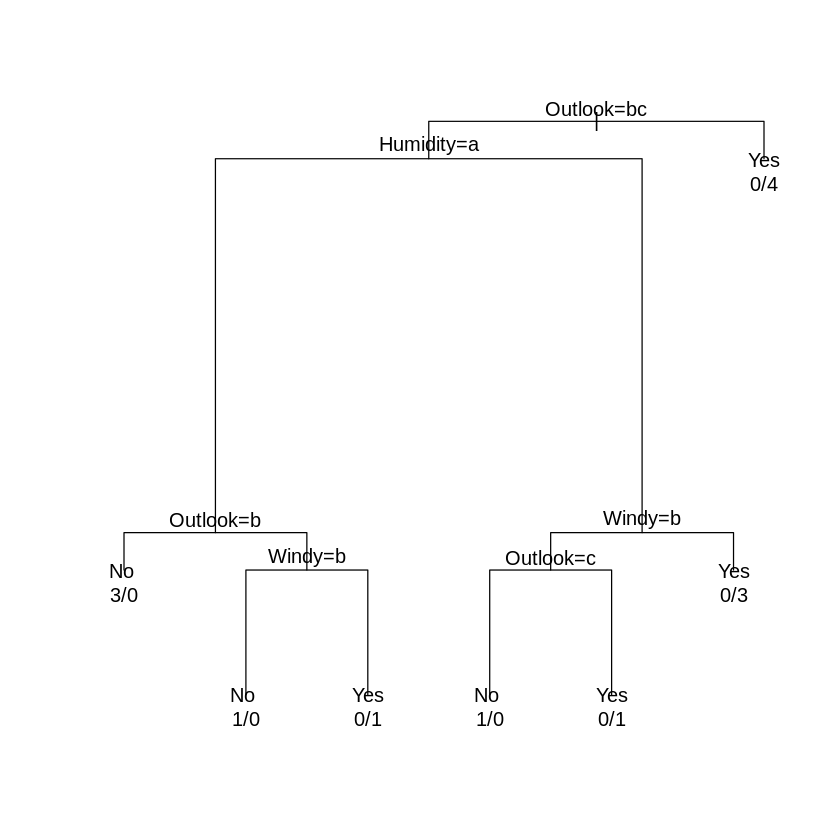

In [14]:
par(xpd = TRUE) #enable things to be drawn outside the plot region
plot(GolfTree, compress = TRUE)
text(GolfTree, use.n = TRUE)